# **Unsmoothing of linear time series**

Let's first import different dependencies and the data:

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
import seaborn as sns

In [123]:
alternative_data_raw = pd.read_excel('EnsaeAlternativeTimeSeries.xlsx', sheet_name='Alternative Asset', index_col=0)
alternative_data_raw.tail(10)

,Commodity - USD Unhedged,Global Property USD Unhedged,Hedge Fund DJ - USD Unhedged,Infrastructure Debt - USD Unhedged,Infrastructure Equity Listed - USD Unhedged,Infrastructure Equity USD Unhedged,Nature Capital - USD Hedged,Private Equity USD Unhedged,UK Property Direct - USD Unhedged
QUARTER,,,,,,,,,
2021-Q2,201.8662,6229.774805,711.43,2534.95,NaN,275.181583,1443.470642,4691.699,278.205508
2021-Q3,215.1673,6184.521678,719.91,2544.31,NaN,271.066062,1515.657205,4897.288,280.913387
2021-Q4,211.8033,6825.772548,726.66,2535.15,6096.56,300.214659,1606.789837,5397.431,305.081135
2022-Q1,265.9137,6568.538826,742.17,2386.29,6552.00,293.265256,1777.360304,4770.109,290.587837
2022-Q2,250.8549,5436.569419,725.12,2267.73,6065.58,263.147689,1890.893920,3612.590,236.794741
2022-Q3,240.5519,4817.520307,727.68,2122.80,5481.12,226.816903,1960.578024,3274.373,187.833995
2022-Q4,245.8892,5159.896609,733.63,2173.62,6086.01,258.409265,2023.095816,3719.178,210.098219
2023-Q1,232.7065,5213.347074,735.54,2241.04,6325.68,250.338364,2026.152916,3976.480,214.263907
2023-Q2,226.7436,5241.647937,748.09,2248.24,6318.26,241.619726,NaN,4311.668,211.147599


# **I. Data Analysis**
## Preprocessing

In [124]:
def tweak_alternative_data(df_):
    return (df_.assign(**{col + '_%y/y': df_[col].pct_change(fill_method = None) for col in df_.columns}) #Adding the returs
            .set_index(pd.to_datetime(df_.index)) #Changing the index format to datetime
            .rename(lambda c: c.replace(' ','_'), axis = 1)) # Replacing the spaces by _ in the names


alternative_data = tweak_alternative_data(alternative_data_raw)
alternative_data.tail(10)

/var/folders/8k/vtlzy2q90b7cbr81gv961g_w0000gn/T/ipykernel_36733/2713308186.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .set_index(pd.to_datetime(df_.index)) #Changing the index format to datetime


,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_Listed_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y
QUARTER,,,,,,,,,,,,,,,,,,
2021-04-01,201.8662,6229.774805,711.43,2534.95,NaN,275.181583,1443.470642,4691.699,278.205508,0.133047,0.094214,0.030222,0.020519,NaN,0.017745,0.111440,0.167016,0.056565
2021-07-01,215.1673,6184.521678,719.91,2544.31,NaN,271.066062,1515.657205,4897.288,280.913387,0.065891,-0.007264,0.011920,0.003692,NaN,-0.014956,0.050009,0.043820,0.009733
2021-10-01,211.8033,6825.772548,726.66,2535.15,6096.56,300.214659,1606.789837,5397.431,305.081135,-0.015634,0.103686,0.009376,-0.003600,NaN,0.107533,0.060127,0.102127,0.086033
2022-01-01,265.9137,6568.538826,742.17,2386.29,6552.00,293.265256,1777.360304,4770.109,290.587837,0.255475,-0.037686,0.021344,-0.058718,0.074704,-0.023148,0.106156,-0.116226,-0.047506
2022-04-01,250.8549,5436.569419,725.12,2267.73,6065.58,263.147689,1890.893920,3612.590,236.794741,-0.056630,-0.172332,-0.022973,-0.049684,-0.074240,-0.102697,0.063878,-0.242661,-0.185118
2022-07-01,240.5519,4817.520307,727.68,2122.80,5481.12,226.816903,1960.578024,3274.373,187.833995,-0.041072,-0.113868,0.003530,-0.063910,-0.096357,-0.138062,0.036852,-0.093622,-0.206764
2022-10-01,245.8892,5159.896609,733.63,2173.62,6086.01,258.409265,2023.095816,3719.178,210.098219,0.022188,0.071069,0.008177,0.023940,0.110359,0.139286,0.031887,0.135844,0.118531
2023-01-01,232.7065,5213.347074,735.54,2241.04,6325.68,250.338364,2026.152916,3976.480,214.263907,-0.053612,0.010359,0.002603,0.031017,0.039380,-0.031233,0.001511,0.069182,0.019827
2023-04-01,226.7436,5241.647937,748.09,2248.24,6318.26,241.619726,NaN,4311.668,211.147599,-0.025624,0.005429,0.017062,0.003213,-0.001173,-0.034827,NaN,0.084293,-0.014544


##  Data Visualisation

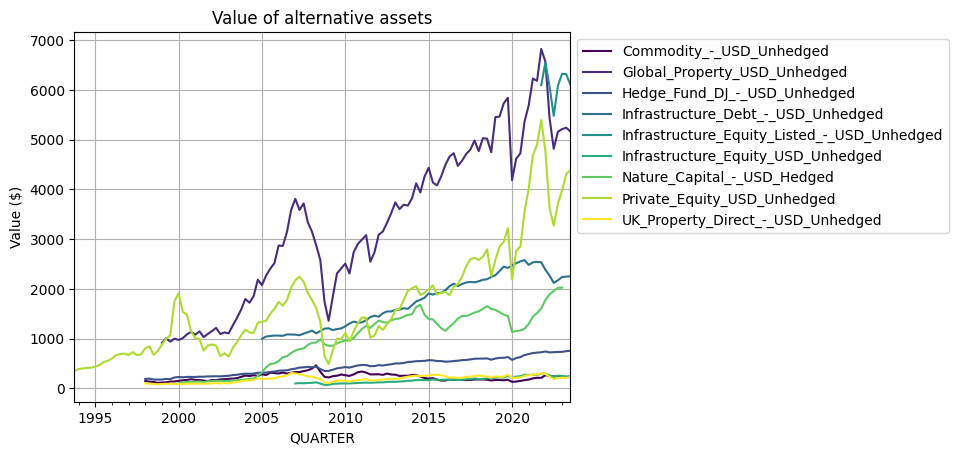

In [125]:
(alternative_data.iloc[:,0:9]
.plot(cmap = 'viridis',grid=True,ylabel='Value ($)', title='Value of alternative assets')
.legend(bbox_to_anchor = (1,1)))

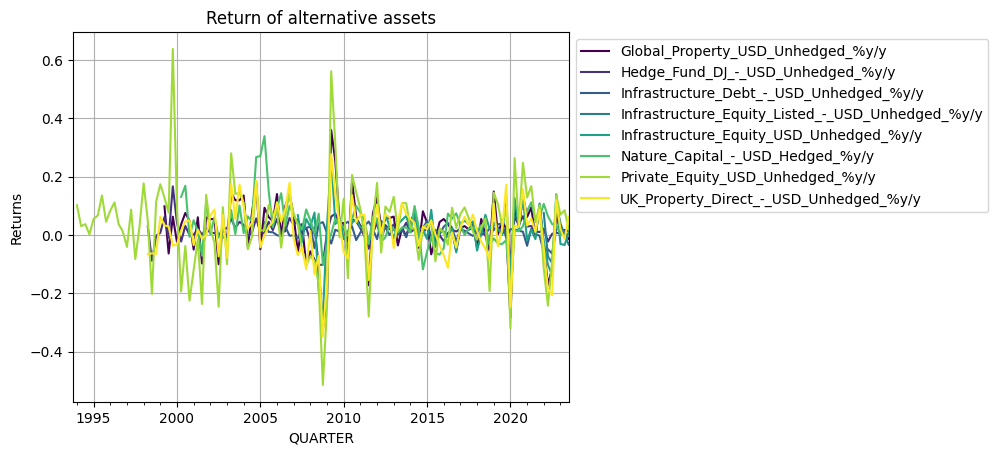

In [126]:
(alternative_data.iloc[:,10:]
.plot(cmap = 'viridis',grid=True,ylabel='Returns', title='Return of alternative assets')
.legend(bbox_to_anchor = (1,1)))

##  Stationarity analysis 

In [127]:
unit_test = {name: (adfuller(alternative_data[name].dropna())[0], adfuller(alternative_data[name].dropna())[1]) 
       for name in alternative_data.iloc[:,10:].columns}

(pd.DataFrame(unit_test, index = ['value','p-value']).T.style.format(precision = 2)
.background_gradient(cmap = 'viridis'))

,value,p-value
Global_Property_USD_Unhedged_%y/y,-8.58,0.00
Hedge_Fund_DJ_-_USD_Unhedged_%y/y,-8.99,0.00
Infrastructure_Debt_-_USD_Unhedged_%y/y,-7.14,0.00
Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,-2.62,0.09
Infrastructure_Equity_USD_Unhedged_%y/y,-8.06,0.00
Nature_Capital_-_USD_Hedged_%y/y,-5.63,0.00
Private_Equity_USD_Unhedged_%y/y,-9.30,0.00
UK_Property_Direct_-_USD_Unhedged_%y/y,-8.59,0.00


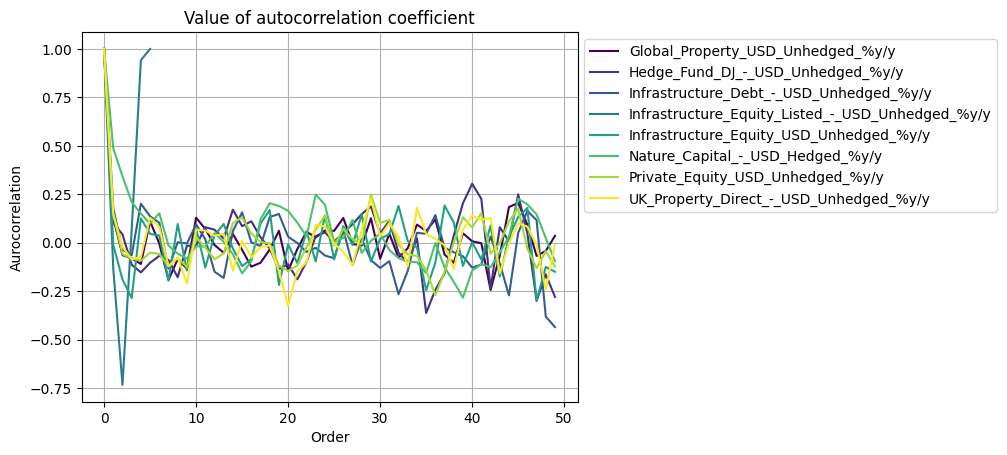

In [128]:
serial_correlation = pd.DataFrame({name:  [alternative_data[name].dropna().autocorr(k) for k in range (50)]
                       for name in alternative_data.iloc[:,10:].columns})

(serial_correlation
.plot(grid = True, cmap  = 'viridis', xlabel='Order', ylabel ='Aurocorrelation', title = 'Value of autocorrelation coefficient' )
.legend(bbox_to_anchor = (1,1)))

# **II. Autoregressive method**
##  Unsmoothing series

In [129]:
from AR_Model.AR_functions import AR_model

In [130]:
def data_unsmoothing(df_):
    new = df_.resample('MS').interpolate(method='polynomial', order = 2)
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed = data_unsmoothing(alternative_data.iloc[:,9:])
unsmoothed.tail(15)

,Commodity_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y,Commodity_-_USD_Unhedged_%y/y_unsmoothed,Global_Property_USD_Unhedged_%y/y_unsmoothed,Hedge_Fund_DJ_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Debt_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Equity_USD_Unhedged_%y/y_unsmoothed,Nature_Capital_-_USD_Hedged_%y/y_unsmoothed,Private_Equity_USD_Unhedged_%y/y_unsmoothed,UK_Property_Direct_-_USD_Unhedged_%y/y_unsmoothed
QUARTER,,,,,,,,,,,,,,,,,,
2022-05-01,-0.093487,-0.176381,-0.020622,-0.055896,-0.102969,-0.132958,0.051144,-0.221291,-0.219314,-0.130344,-0.180431,-0.018270,-0.062109,-0.131698,-0.163219,0.038411,-0.199921,-0.253510
2022-06-01,-0.071021,-0.155571,-0.006895,-0.067673,-0.117865,-0.161746,0.042215,-0.164770,-0.240757,-0.048555,-0.134760,0.006832,-0.079449,-0.132760,-0.190535,0.033286,-0.108249,-0.262200
2022-07-01,-0.041072,-0.113868,0.003530,-0.063910,-0.096357,-0.138062,0.036852,-0.093622,-0.206764,-0.011122,-0.072164,0.013956,-0.060147,-0.074849,-0.114378,0.031490,-0.022474,-0.172772
2022-08-01,-0.010510,-0.048953,0.008921,-0.040776,-0.033209,-0.051677,0.034556,-0.006074,-0.107801,0.020051,0.015961,0.014312,-0.017642,0.029940,0.034708,0.032260,0.081474,-0.008838
2022-09-01,0.016477,0.029372,0.009401,-0.002668,0.059176,0.077943,0.034617,0.087023,0.036949,0.043465,0.107697,0.009880,0.035439,0.151562,0.207563,0.034677,0.180119,0.181698
2022-10-01,0.022188,0.071069,0.008177,0.023940,0.110359,0.139286,0.031887,0.135844,0.118531,0.027898,0.112766,0.006953,0.050549,0.161541,0.200628,0.029158,0.184666,0.200114
2022-11-01,0.004206,0.071213,0.005659,0.036792,0.112890,0.119134,0.025360,0.135991,0.125601,-0.013775,0.071356,0.003141,0.049643,0.115420,0.098982,0.018832,0.136138,0.132671
2022-12-01,-0.031156,0.036844,0.002607,0.036375,0.074151,0.033377,0.015454,0.096193,0.069347,-0.066519,0.002475,-0.000445,0.035958,0.035412,-0.052379,0.005549,0.056395,0.013093
2023-01-01,-0.053612,0.010359,0.002603,0.031017,0.039380,-0.031233,0.001511,0.069182,0.019827,-0.076069,-0.016126,0.002600,0.025660,0.004610,-0.095843,-0.012432,0.042172,-0.029693


## Results visualisation

### Cumulated returns:

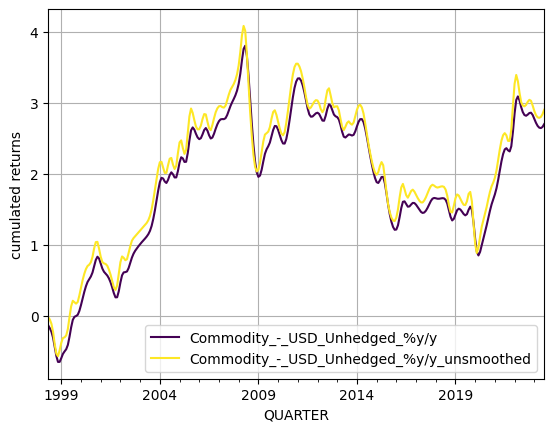

In [131]:
(unsmoothed.iloc[:,[0,9]].cumsum().dropna()
.plot(grid = True, cmap = 'viridis',ylabel='cumulated returns')
.legend())

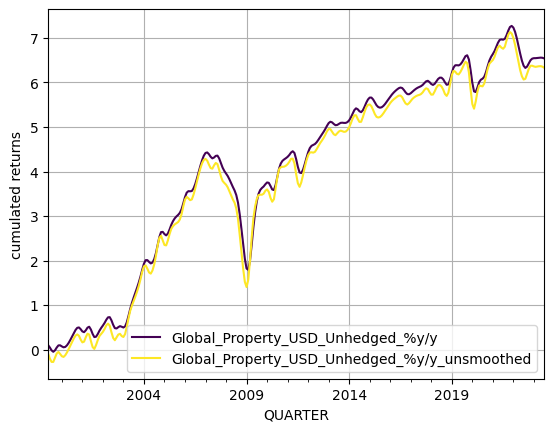

In [132]:
(unsmoothed.iloc[:,[1,10]].cumsum().dropna()
.plot(grid = True, cmap = 'viridis',ylabel='cumulated returns')
.legend())


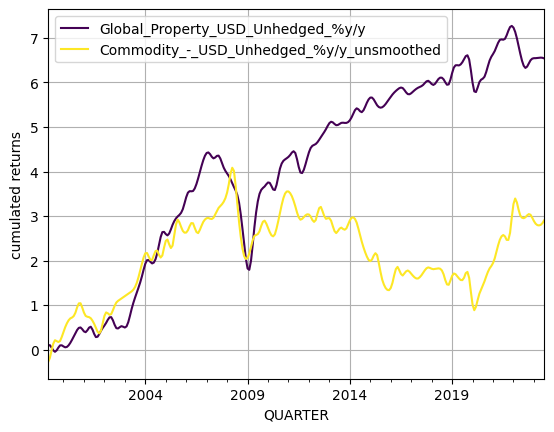

In [133]:
(unsmoothed.iloc[:,[1,9]].cumsum().dropna()
.plot(grid = True, cmap = 'viridis',ylabel='cumulated returns')
.legend())


### Interpolation:

Text(0.5, 1.0, 'Year 2018 interpolation')

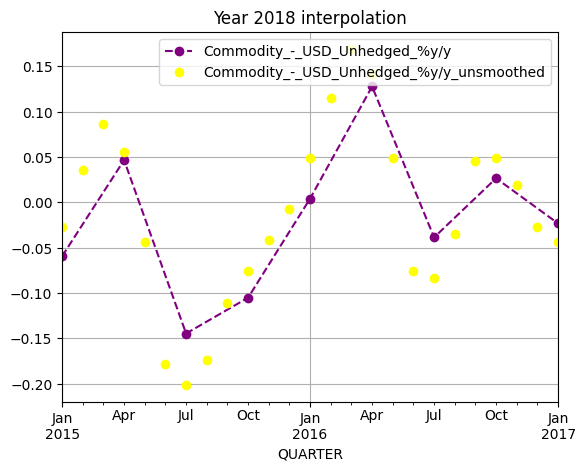

In [134]:
fig, axis = plt.subplots()
(unsmoothed.loc['2015-01-01':'2017-01-01', unsmoothed.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'purple')
 .legend())

(unsmoothed.loc['2015-01-01':'2017-01-01',unsmoothed.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='yellow')
.legend())

axis.set_title('Year 2018 interpolation')

###  Serial correlation:

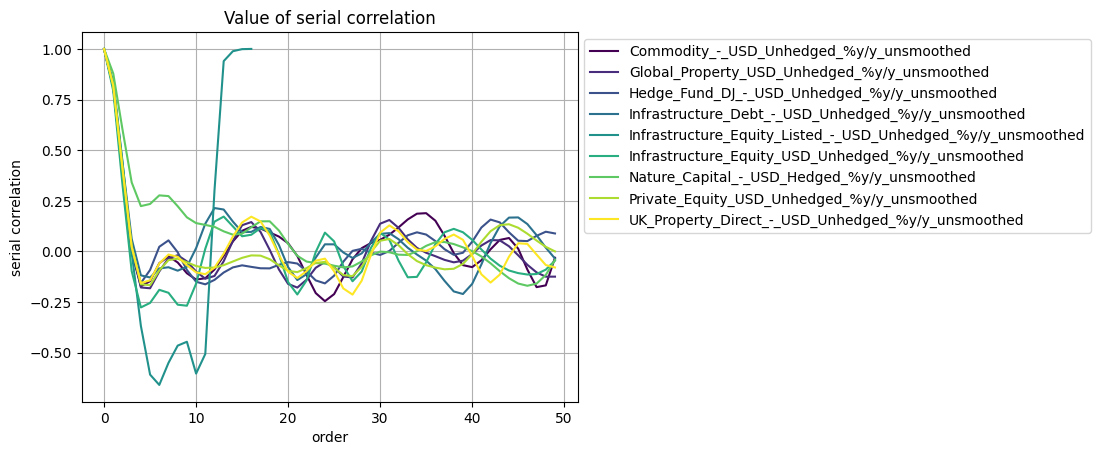

In [135]:
serial_correlation_unsmoothed = pd.DataFrame({name:[unsmoothed[name].dropna().autocorr(k) for k in range (50)]
for name in unsmoothed.iloc[:,9:].columns})

(serial_correlation_unsmoothed
.plot(grid = True, cmap  = 'viridis', xlabel='order', ylabel ='serial correlation', title = 'Value of serial correlation' )
.legend(bbox_to_anchor = (1,1)))

In [136]:
unsmoothed.tail()

,Commodity_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y,Commodity_-_USD_Unhedged_%y/y_unsmoothed,Global_Property_USD_Unhedged_%y/y_unsmoothed,Hedge_Fund_DJ_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Debt_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Equity_USD_Unhedged_%y/y_unsmoothed,Nature_Capital_-_USD_Hedged_%y/y_unsmoothed,Private_Equity_USD_Unhedged_%y/y_unsmoothed,UK_Property_Direct_-_USD_Unhedged_%y/y_unsmoothed
QUARTER,,,,,,,,,,,,,,,,,,
2023-03-01,-0.043653,0.003636,0.012477,0.011611,0.008436,-0.048436,NaN,0.078917,-0.017372,-0.030963,0.006816,0.018525,0.001186,-0.001008,-0.040751,NaN,0.092139,-0.026032
2023-04-01,-0.025624,0.005429,0.017062,0.003213,-0.001173,-0.034827,NaN,0.084293,-0.014544,-0.007595,0.007221,0.021647,-0.005186,-0.010782,-0.021218,NaN,0.089668,-0.011717
2023-05-01,-0.006188,0.003077,0.018612,-0.000882,-0.011211,-0.020959,NaN,0.075963,-0.000402,0.013249,0.000725,0.020162,-0.004977,-0.021249,-0.007090,NaN,0.067634,0.013740
2023-06-01,0.015953,-0.003577,0.017231,-0.000946,-0.022348,-0.005906,NaN,0.053374,0.025997,0.038093,-0.010230,0.015849,-0.001010,-0.033484,0.009147,NaN,0.030785,0.052397
2023-07-01,0.039368,-0.014102,0.013006,0.003025,-0.033864,0.009360,NaN,0.017983,0.062951,0.062783,-0.024627,0.008782,0.006995,-0.045380,0.024627,NaN,-0.017408,0.099904


### Volatility:

In [137]:
import numpy as np

def volatility_from_month(x):
    return np.sqrt(12)*x.std()

<Axes: xlabel='QUARTER'>

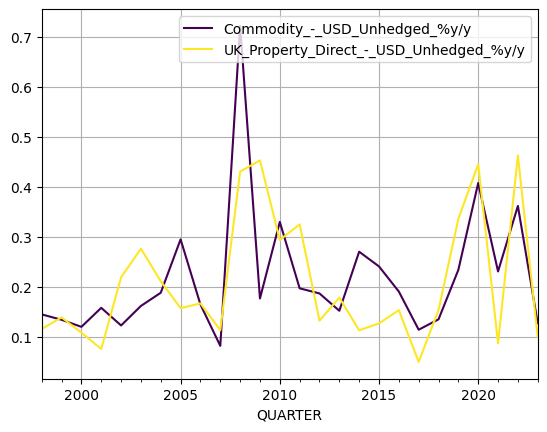

In [138]:
(unsmoothed.iloc[:,[0,8]].resample('YS')
.agg(volatility_from_month)
.dropna()
.plot(grid = True, cmap = 'viridis'))

In [139]:
(unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" not in col]].resample('YS')
.agg(volatility_from_month)
.dropna())

,Commodity_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y
QUARTER,,,,,,,,,
2022-01-01,0.361507,0.328116,0.045987,0.141998,0.297574,0.354243,0.10198,0.51481,0.462338


<Axes: xlabel='QUARTER'>

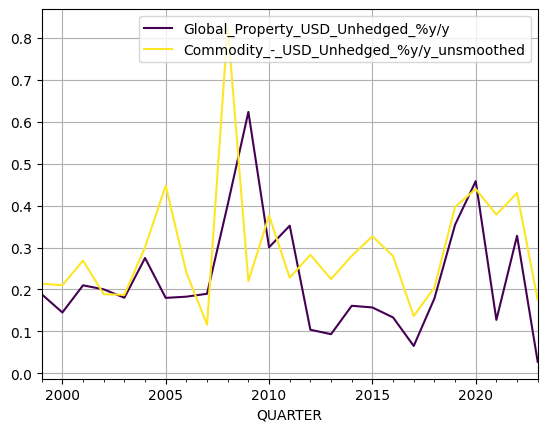

In [140]:
(unsmoothed.iloc[:,[1,9]].resample('YS')
.agg(volatility_from_month)
.dropna()
.plot(grid = True, cmap = 'viridis'))

In [141]:
(unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" in col]].resample('YS')
.agg(volatility_from_month)
.dropna())

,Commodity_-_USD_Unhedged_%y/y_unsmoothed,Global_Property_USD_Unhedged_%y/y_unsmoothed,Hedge_Fund_DJ_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Debt_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Equity_USD_Unhedged_%y/y_unsmoothed,Nature_Capital_-_USD_Hedged_%y/y_unsmoothed,Private_Equity_USD_Unhedged_%y/y_unsmoothed,UK_Property_Direct_-_USD_Unhedged_%y/y_unsmoothed
QUARTER,,,,,,,,,
2022-01-01,0.430359,0.407904,0.061638,0.177018,0.389447,0.468949,0.107022,0.619723,0.586522


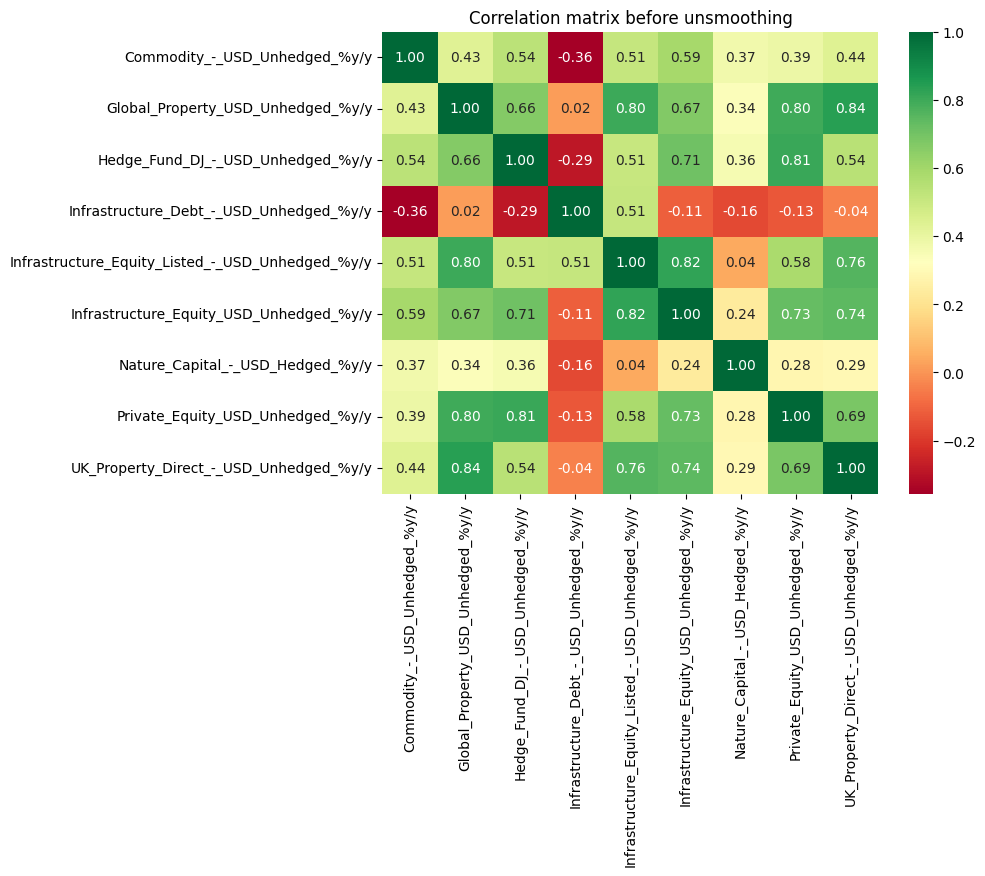

In [142]:
plt.figure(figsize=(8, 6))
corr_matrix  = alternative_data[['Commodity_-_USD_Unhedged_%y/y','Global_Property_USD_Unhedged_%y/y','Hedge_Fund_DJ_-_USD_Unhedged_%y/y'
                                 ,'Infrastructure_Debt_-_USD_Unhedged_%y/y','Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y','Infrastructure_Equity_USD_Unhedged_%y/y'
                                 ,'Nature_Capital_-_USD_Hedged_%y/y','Private_Equity_USD_Unhedged_%y/y','UK_Property_Direct_-_USD_Unhedged_%y/y']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation matrix before unsmoothing')
plt.show()

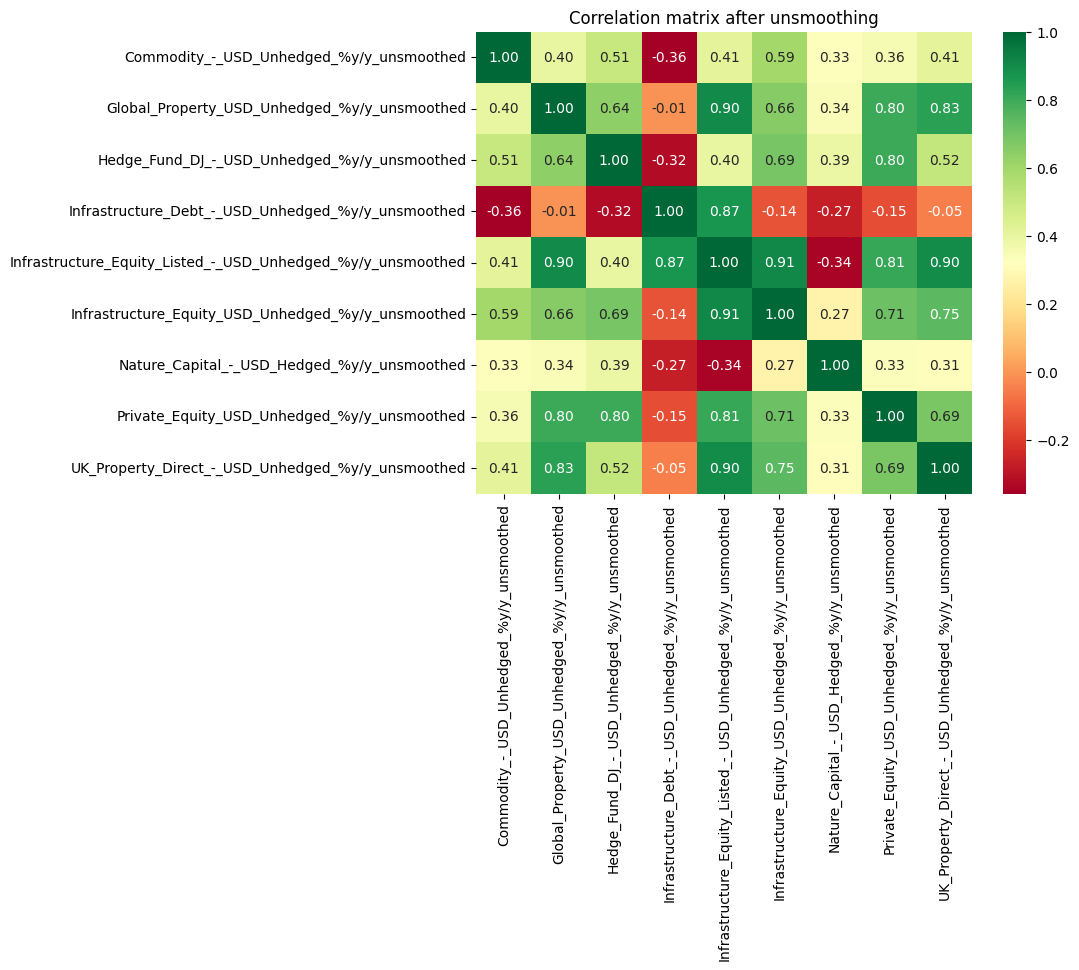

In [143]:
plt.figure(figsize=(8, 6))
corr_matrix  = unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" in col]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation matrix after unsmoothing')
plt.show()

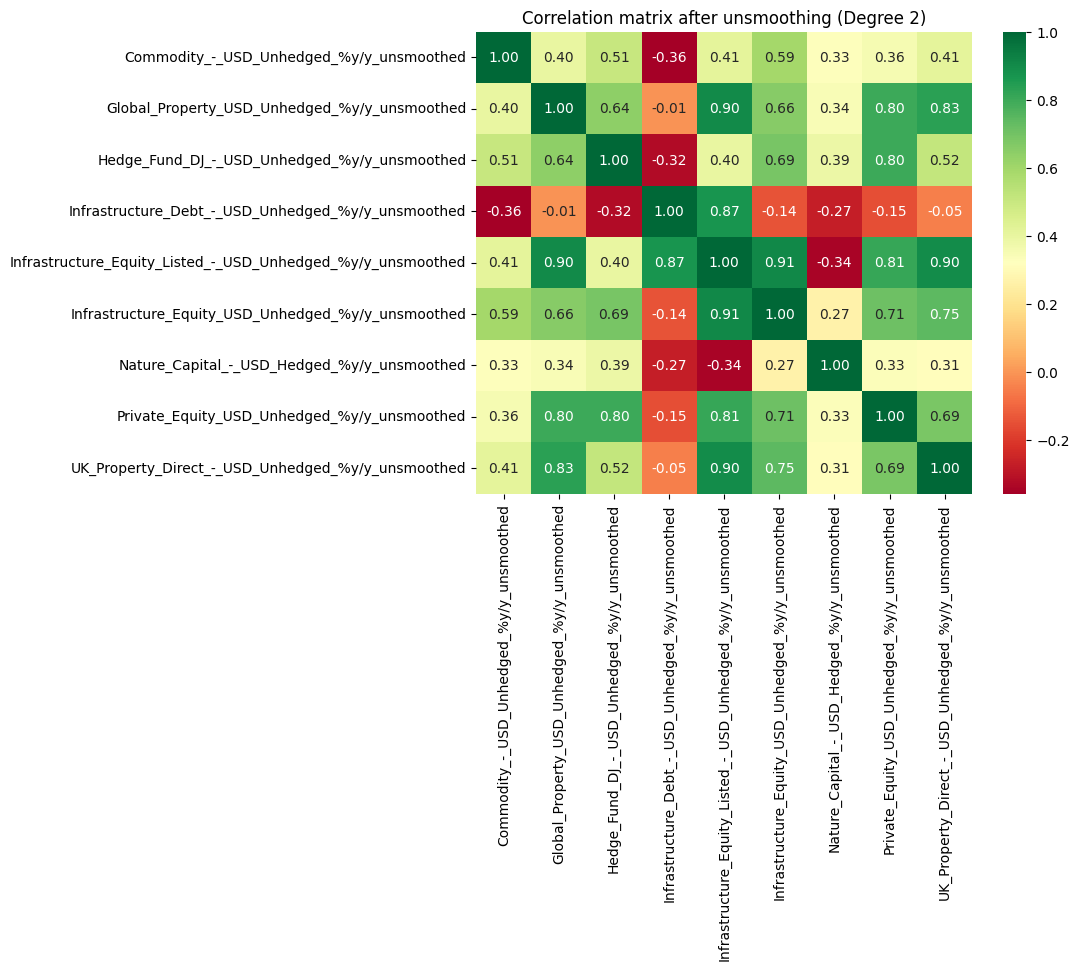

In [144]:
plt.figure(figsize=(8, 6))
corr_matrix  = unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" in col]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation matrix after unsmoothing (Degree 2)')
plt.show()

## Alternative: Linear interpolation
###  Applying linear interpolation:

In [145]:
def data_unsmoothing_linear(df_):
    new = df_.resample('MS').interpolate(method='linear')
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed_linear = data_unsmoothing_linear(alternative_data.iloc[:,9:])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Text(0.5, 1.0, 'Year 2018 interpolation')

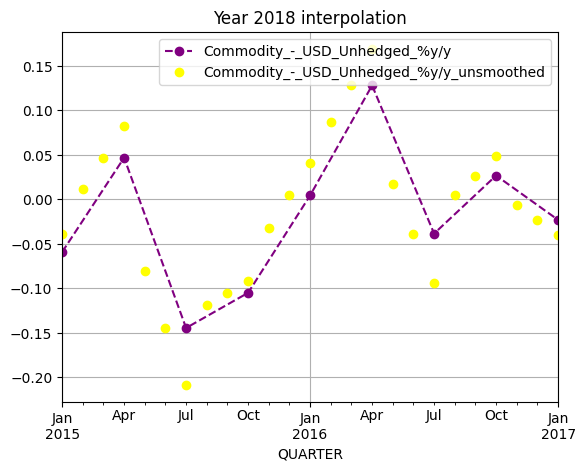

In [146]:
fig, axis = plt.subplots()
(unsmoothed_linear.loc['2015-01-01':'2017-01-01', unsmoothed_linear.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'purple')
 .legend())

(unsmoothed_linear.loc['2015-01-01':'2017-01-01',unsmoothed_linear.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='yellow')
.legend())

axis.set_title('Year 2018 interpolation')

In [147]:
unsmoothed_linear["Global_Property_USD_Unhedged_%y/y"]

QUARTER
1993-10-01         NaN
1993-11-01         NaN
1993-12-01         NaN
1994-01-01         NaN
1994-02-01         NaN
                ...   
2023-03-01    0.007072
2023-04-01    0.005429
2023-05-01   -0.001082
2023-06-01   -0.007592
2023-07-01   -0.014102
Freq: MS, Name: Global_Property_USD_Unhedged_%y/y, Length: 358, dtype: float64

Text(0.5, 1.0, 'Year 2018 interpolation: Linear vs Quadratic')

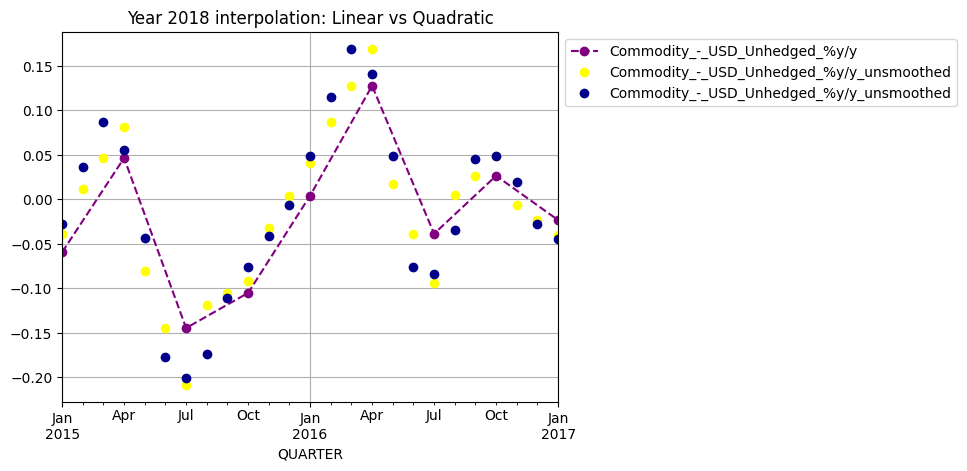

In [148]:
fig, axis = plt.subplots()
(unsmoothed_linear.loc['2015-01-01':'2017-01-01', unsmoothed_linear.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'purple')
 .legend())

(unsmoothed_linear.loc['2015-01-01':'2017-01-01',unsmoothed_linear.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='yellow')
.legend())

(unsmoothed.loc['2015-01-01':'2017-01-01',unsmoothed.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='darkblue')
.legend(bbox_to_anchor = (1,1)))

axis.set_title('Year 2018 interpolation: Linear vs Quadratic')

### Correlation matrix for Linear desmoothing

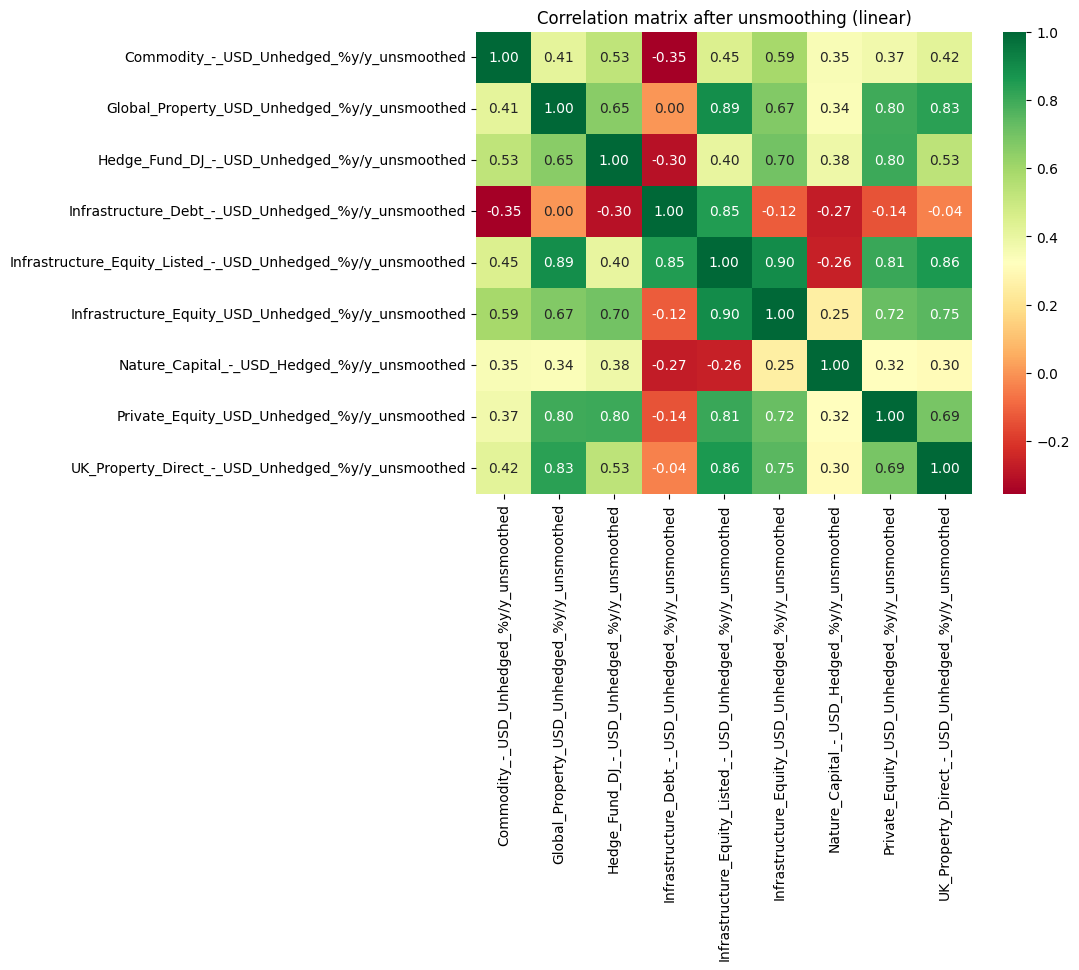

In [149]:
plt.figure(figsize=(8, 6))
corr_matrix  = unsmoothed_linear[[col for col in unsmoothed_linear.columns if "unsmoothed" in col]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation matrix after unsmoothing (linear)')
plt.show()

### Rolling window (Eh bah non)

In [150]:
def data_unsmoothing(df_):
    new = df_.resample('MS').interpolate(method='polynomial', order = 2)
    for col in df_.columns:
        new[col + '_unsmoothed'] = new[col].rolling(window = 5).apply(lambda x: AR_model(x.to_numpy()))
    return new


unsmoothed = data_unsmoothing(alternative_data.iloc[:,10:])
unsmoothed.tail(15)

TypeError: only length-1 arrays can be converted to Python scalars

## **III. Getmansky, Lo, Makarov Model**

In [ ]:
from web_app.apps.Models.getmansky.GetmanskyMain import GetmanskyModel

In [ ]:
alternative_asset_data = (
    # Importing the dataset
    pd.read_excel("./EnsaeAlternativeTimeSeries.xlsx", sheet_name= "Alternative Asset", index_col=0)
)

def tweak_data(df_):
    return (df_
            .assign(**{col + '_%y/y': df_[col].pct_change(fill_method = None) for col in df_.columns})
            .rename(lambda c: c.replace(' ','_'), axis = 1)
        )

alternative_asset_data = tweak_data(alternative_asset_data)[1:]
alternative_asset_data

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_Listed_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y
QUARTER,,,,,,,,,,,,,,,,,,
1994-Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,389.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101506,NaN
1994-Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029835,NaN
1994-Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036681,NaN
1994-Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,416.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001613,NaN
1995-Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054864,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-Q3,240.5519,4817.520307,727.68,2122.80,5481.12,226.816903,1960.578024,3274.373,187.833995,-0.041072,-0.113868,0.003530,-0.063910,-0.096357,-0.138062,0.036852,-0.093622,-0.206764
2022-Q4,245.8892,5159.896609,733.63,2173.62,6086.01,258.409265,2023.095816,3719.178,210.098219,0.022188,0.071069,0.008177,0.023940,0.110359,0.139286,0.031887,0.135844,0.118531
2023-Q1,232.7065,5213.347074,735.54,2241.04,6325.68,250.338364,2026.152916,3976.480,214.263907,-0.053612,0.010359,0.002603,0.031017,0.039380,-0.031233,0.001511,0.069182,0.019827


In [ ]:
classic_asset_data = (
    # Importing the dataset
    pd.read_excel("/Users/adamelbernoussi/Desktop/EnsaeAlternativeSubject/EnsaeAlternativeTimeSeries.xlsx", sheet_name= "Classic Asset", index_col=1)
)

def tweak_data(df_):
    return (
        df_
        .resample('ME')
        .last()
        .assign(**{col + '_%y/y': df_[col].pct_change(fill_method = None) for col in df_.columns if df_[col].dtype != object})
        .rename(lambda c: c.replace(' ','_'), axis = 1)
        .reset_index()
        .assign(QUARTER=lambda x: x["QUARTER"].bfill()) #only one value is missing in the dataframe
        .set_index("QUARTER")        
    )

classic_asset_data = tweak_data(classic_asset_data)[1:]
classic_asset_data

,Date,Liquidity_USD_Unhedged,US_Equity_USD_Unhedged,US_Government_Bond_USD_Unhedged,USD_Corporate_Bond_-_USD_Unhedged,Liquidity_USD_Unhedged_%y/y,US_Equity_USD_Unhedged_%y/y,US_Government_Bond_USD_Unhedged_%y/y,USD_Corporate_Bond_-_USD_Unhedged_%y/y
QUARTER,,,,,,,,,
1998-Q1,1998-03-31,146.135886,3099.360000,242.190000,952.750061,0.004613,0.052027,0.002733,0.003693
1998-Q2,1998-04-30,146.872656,3136.193000,243.270000,958.766296,0.005042,0.011884,0.004459,0.006315
1998-Q2,1998-05-31,147.551539,3073.750000,245.790000,970.149414,0.004622,-0.019910,0.010359,0.011873
1998-Q2,1998-06-30,148.232494,3206.355000,248.630000,977.322327,0.004615,0.043141,0.011555,0.007394
1998-Q3,1998-07-31,149.008144,3175.110000,249.020000,976.397705,0.005233,-0.009745,0.001569,-0.000946
...,...,...,...,...,...,...,...,...,...
2023-Q2,2023-04-30,118.444827,18414.905335,604.922865,3095.666047,NaN,NaN,NaN,NaN
2023-Q2,2023-05-31,118.990836,18534.693812,597.900543,3050.833843,0.000143,-0.005608,0.003326,0.002719
2023-Q2,2023-06-30,119.497744,19770.619413,593.410756,3063.387009,0.000142,0.012186,0.002510,0.005197


In [ ]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2012-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = None # choose an int or put None
benchmark = 'US_Equity_USD_Unhedged_%y/y' #one of the following list :
# 'Liquidity_USD_Unhedged_%y/y'
# 'US_Equity_USD_Unhedged_%y/y'
# 'US_Government_Bond_USD_Unhedged_%y/y'
# 'USD_Corporate_Bond_-_USD_Unhedged_%y/y'


df = (
    classic_asset_data
    .copy()
    .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
    .set_index("Date")
    .loc[start_date:end_date]
    .iloc[1:]
)

#deal with potential missing values
if df.isna().any().any():
    df.interpolate(method='linear', inplace=True)

for col in filter(lambda x: "%y/y" in x, alternative_asset_data.columns):
    getmansky = GetmanskyModel(order)

    if weight_type != "optimized":
        getmansky.set_default_weights(weight_type)
    else:
        getmansky.optimize_weights_LR(df[benchmark].values.reshape(-1, 1), 
                  df[col].values.reshape(-1,1)
                )
    index = df[col].dropna().index
    if len(index)>3:
        bench = df.loc[index, benchmark]

        getmansky.fit(bench.values.reshape(-1, 1), 
                    df[col].dropna().values.reshape(-1,1), 
                    window = window
                    )
        df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench)
        print(getmansky.beta, getmansky.mu)
    else:
        warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
        df[col+'_unsmoothed'] = 0


df = (
    df
    .assign(**{
        col: df[col].mul(pd.Series(
            [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df[col].index],
            index = df[col].index
            )) 
        for col in alternative_asset_data.columns
    })
    .pipe(lambda df_temp: df_temp.assign(**{
        col + '_TR': (df_temp[col]+1).cumprod()-1
        for col in df_temp.columns if "%y/y" in col
    }))
)
df

0.8343705562670167 -0.0016539561059609061
1.3919698067073398 -0.003255500685518196
0.4005378837690121 0.002219570776792408
-0.1417288235155248 0.005612424120097493
0.7544285637324992 0.0028024624469992253
0.2986421395672264 0.008985639981609466
2.159504611470584 -0.009853105942138727
1.1573592316881376 -0.007690207109388722


/var/folders/8k/vtlzy2q90b7cbr81gv961g_w0000gn/T/ipykernel_36733/3346988615.py:46: UserWarning: Be careful, Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y has no value for the selected timeframe.
  warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")


,Liquidity_USD_Unhedged,US_Equity_USD_Unhedged,US_Government_Bond_USD_Unhedged,USD_Corporate_Bond_-_USD_Unhedged,Liquidity_USD_Unhedged_%y/y,US_Equity_USD_Unhedged_%y/y,US_Government_Bond_USD_Unhedged_%y/y,USD_Corporate_Bond_-_USD_Unhedged_%y/y,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,...,UK_Property_Direct_-_USD_Unhedged_%y/y_TR,Commodity_-_USD_Unhedged_%y/y_unsmoothed_TR,Global_Property_USD_Unhedged_%y/y_unsmoothed_TR,Hedge_Fund_DJ_-_USD_Unhedged_%y/y_unsmoothed_TR,Infrastructure_Debt_-_USD_Unhedged_%y/y_unsmoothed_TR,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y_unsmoothed_TR,Infrastructure_Equity_USD_Unhedged_%y/y_unsmoothed_TR,Nature_Capital_-_USD_Hedged_%y/y_unsmoothed_TR,Private_Equity_USD_Unhedged_%y/y_unsmoothed_TR,UK_Property_Direct_-_USD_Unhedged_%y/y_unsmoothed_TR
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-31,204.050694,4364.117706,387.873655,1592.612523,0.004478,0.034173,0.005071,0.008092,0.0000,0.00,...,0.000000,0.026859,0.044313,0.015907,0.000769,0,NaN,0.019191,0.063944,0.031861
2006-11-30,205.020181,4450.718819,391.925493,1615.955209,0.004751,0.019844,0.010446,0.014657,0.0000,0.00,...,0.000000,0.042163,0.069759,0.026237,0.003571,0,NaN,0.034389,0.099054,0.047624
2006-12-31,205.906332,4504.774211,388.704526,1601.263524,0.004322,0.012145,-0.008218,-0.009092,314.0230,3588.68,...,0.178536,0.051000,0.084362,0.033507,0.007476,0,NaN,0.047436,0.117051,0.054293
2007-01-31,206.853761,4586.412592,388.084362,1601.383171,0.004601,0.018123,-0.001595,0.000075,0.0000,0.00,...,0.178536,0.064161,0.106478,0.042834,0.010704,0,NaN,0.062163,0.147031,0.066917
2007-02-28,207.720170,4502.527598,394.520124,1634.362033,0.004189,-0.018290,0.016583,0.020594,0.0000,0.00,...,0.178536,0.070450,0.116837,0.048936,0.015078,0,NaN,0.074582,0.158184,0.069906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-31,232.693694,4731.220180,550.366830,2322.064724,0.000745,-0.061439,0.017139,0.007549,0.0000,0.00,...,-0.331296,0.096790,0.087102,0.292912,0.404452,0,0.337585,0.990361,-0.244695,-0.226765
2012-06-30,232.849898,4918.302088,548.452857,2330.301007,0.000671,0.039542,-0.003478,0.003547,272.3567,3155.02,...,-0.328264,0.079507,0.057984,0.287028,0.415699,0,0.324276,0.998198,-0.279708,-0.247838
2012-07-31,233.013549,4984.978011,553.974731,2397.351858,0.000703,0.013557,0.010068,0.028773,0.0000,0.00,...,-0.328264,0.063959,0.032039,0.282008,0.426710,0,0.312722,1.007035,-0.310571,-0.266923


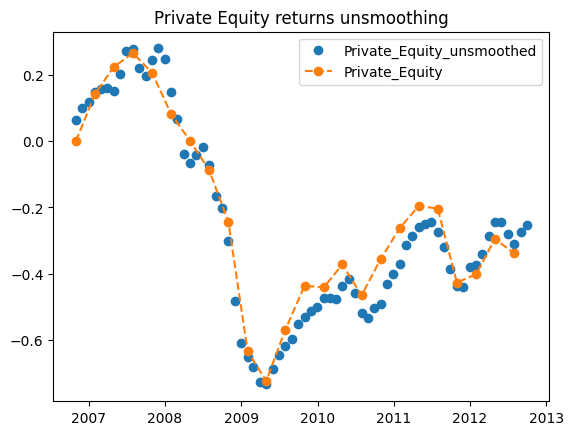

In [ ]:
fig, axes = plt.subplots()

plt.title("Private Equity returns unsmoothing")

plt.plot(df.index, df["Private_Equity_USD_Unhedged_%y/y_unsmoothed_TR"],
        marker = 'o',
        linestyle = '',
        label = "Private_Equity_unsmoothed")
plt.plot(df.index[::3], df['Private_Equity_USD_Unhedged_%y/y_TR'].iloc[::3],
        marker = 'o',
        linestyle = '--',
        label = "Private_Equity")

plt.legend()
plt.show()

In [ ]:
print("volatilité annualisé :")
volatility = pd.DataFrame({"volatilité" : [df[name+"_unsmoothed"].dropna().std()*np.sqrt(12)
for name in alternative_asset_data.columns if "%y/y" in name]}, index = [name+"_unsmoothed" for name in alternative_asset_data.columns if "%y/y" in name])
volatility

volatilité annualisé :


,volatilité
Commodity_-_USD_Unhedged_%y/y_unsmoothed,0.104083
Global_Property_USD_Unhedged_%y/y_unsmoothed,0.173641
Hedge_Fund_DJ_-_USD_Unhedged_%y/y_unsmoothed,0.049965
Infrastructure_Debt_-_USD_Unhedged_%y/y_unsmoothed,0.017680
Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y_unsmoothed,0.000000
Infrastructure_Equity_USD_Unhedged_%y/y_unsmoothed,0.098501
Nature_Capital_-_USD_Hedged_%y/y_unsmoothed,0.037254
Private_Equity_USD_Unhedged_%y/y_unsmoothed,0.269386
UK_Property_Direct_-_USD_Unhedged_%y/y_unsmoothed,0.144374


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


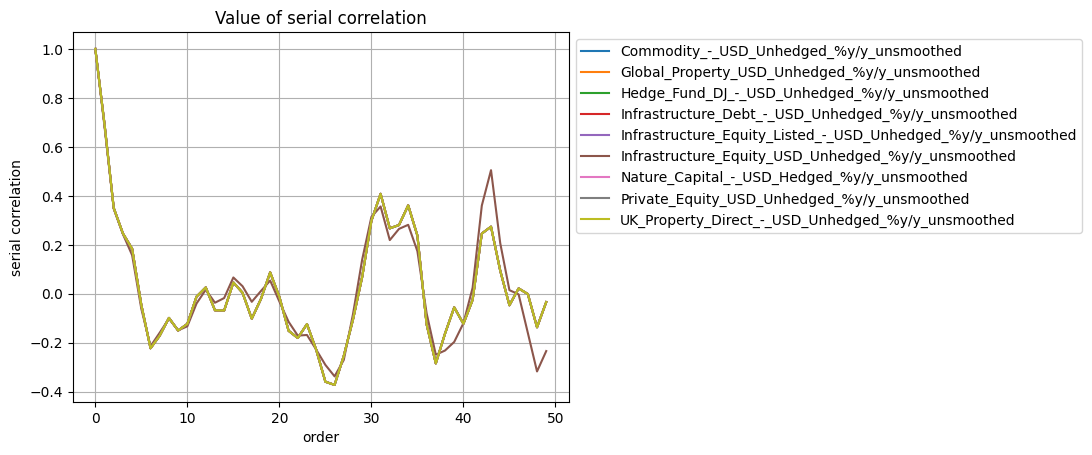

In [ ]:
serial_correlation = pd.DataFrame({name+"_unsmoothed":[df[name+"_unsmoothed"].dropna().autocorr(k) for k in range (50)]
for name in alternative_asset_data.columns if "%y/y" in name})

(serial_correlation
.plot(grid = True, xlabel='order', ylabel ='serial correlation', title = 'Value of serial correlation' )
.legend(bbox_to_anchor = (1,1)))

warnings.filterwarnings('ignore', category=RuntimeWarning)

plt.show()

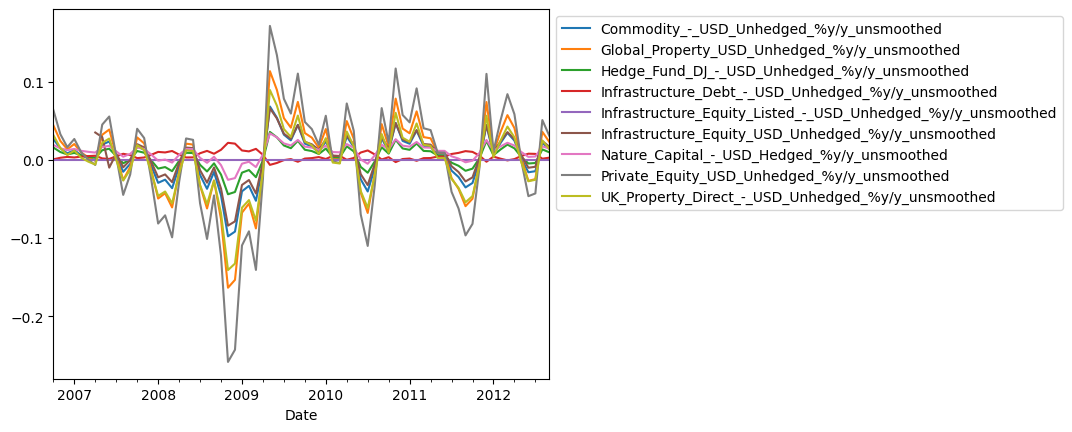

In [ ]:
(df[[col for col in df.columns if "%y/y_unsmoothed" in col and "TR" not in col]].plot()
    .legend(bbox_to_anchor = (1,1)))

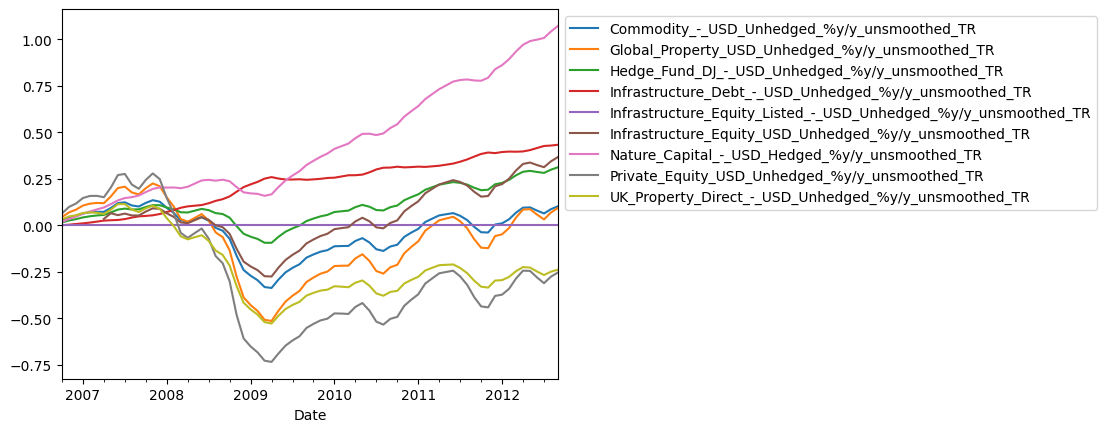

In [ ]:
(df[[col for col in df.columns if "%y/y_unsmoothed_TR" in col]].plot()
    .legend(bbox_to_anchor = (1,1)))

### Getmansky avec window

In [ ]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2016-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = 12 # choose an int or put None
benchmark = 'US_Equity_USD_Unhedged_%y/y' #one of the following list :
# 'Liquidity_USD_Unhedged_%y/y'
# 'US_Equity_USD_Unhedged_%y/y'
# 'US_Government_Bond_USD_Unhedged_%y/y'
# 'USD_Corporate_Bond_-_USD_Unhedged_%y/y'


df = (
    classic_asset_data
    .copy()
    .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
    .set_index("Date")
    .loc[start_date:end_date]
    .iloc[1:]
)

#deal with potential missing values
if df.isna().any().any():
    df.interpolate(method='linear', inplace=True)

for col in filter(lambda x: "%y/y" in x, alternative_asset_data.columns):
    getmansky = GetmanskyModel(order)

    if weight_type != "optimized":
        getmansky.set_default_weights(weight_type)
    else:
        getmansky.optimize_weights_LR(df[benchmark].values.reshape(-1, 1), 
                  df[col].values.reshape(-1,1)
                )
    index = df[col].dropna().index
    if len(index)>3:
        bench = df.loc[index, benchmark]

        getmansky.fit(bench.values.reshape(-1, 1), 
                    df[col].dropna().values.reshape(-1,1), 
                    window = window
                    )
        df[col+'_unsmoothed'] = np.nan
        df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench)
    else:
        warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
        df[col+'_unsmoothed'] = 0


df = (
    df
    .assign(**{
        col: df[col].mul(pd.Series(
            [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df[col].index],
            index = df[col].index
            )) 
        for col in alternative_asset_data.columns
    })
    .pipe(lambda df_temp: df_temp.assign(**{
        col + '_TR': (df_temp[col]+1).cumprod()-1
        for col in df_temp.columns if "%y/y" in col
    }))
)


/var/folders/8k/vtlzy2q90b7cbr81gv961g_w0000gn/T/ipykernel_36733/2052305397.py:46: UserWarning: Be careful, Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y has no value for the selected timeframe.
  warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")


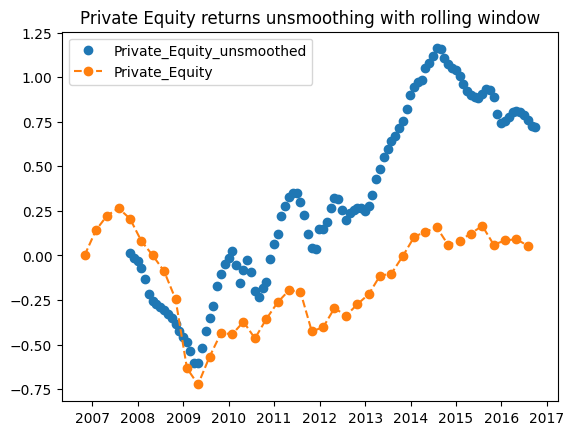

In [ ]:
fig, axes = plt.subplots()

plt.title("Private Equity returns unsmoothing with rolling window")

plt.plot(df.index, df["Private_Equity_USD_Unhedged_%y/y_unsmoothed_TR"],
        marker = 'o',
        linestyle = '',
        label = "Private_Equity_unsmoothed")
plt.plot(df.index[::3], df['Private_Equity_USD_Unhedged_%y/y_TR'].iloc[::3],
        marker = 'o',
        linestyle = '--',
        label = "Private_Equity")

plt.legend()
plt.show()

In [ ]:
print("volatilité annualisé :")
volatility = pd.DataFrame({"volatilité" : [df[name+"_unsmoothed"].dropna().std()*np.sqrt(12)
for name in alternative_asset_data.columns if "%y/y" in name]}, index = [name+"_unsmoothed" for name in alternative_asset_data.columns if "%y/y" in name])
volatility

volatilité annualisé :


,volatilité
Commodity_-_USD_Unhedged_%y/y_unsmoothed,0.155379
Global_Property_USD_Unhedged_%y/y_unsmoothed,0.121007
Hedge_Fund_DJ_-_USD_Unhedged_%y/y_unsmoothed,0.059279
Infrastructure_Debt_-_USD_Unhedged_%y/y_unsmoothed,0.042973
Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y_unsmoothed,0.000000
Infrastructure_Equity_USD_Unhedged_%y/y_unsmoothed,0.107798
Nature_Capital_-_USD_Hedged_%y/y_unsmoothed,0.072669
Private_Equity_USD_Unhedged_%y/y_unsmoothed,0.206294
UK_Property_Direct_-_USD_Unhedged_%y/y_unsmoothed,0.122257


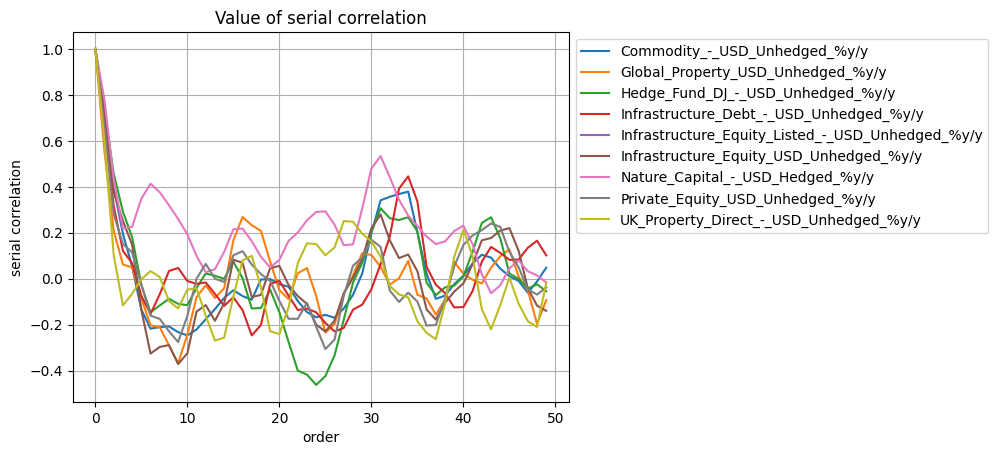

In [ ]:
serial_correlation = pd.DataFrame({name:[df[name+"_unsmoothed"].dropna().autocorr(k) for k in range (50)]
for name in alternative_asset_data.columns if "%y/y" in name})

(serial_correlation
.plot(grid = True, xlabel='order', ylabel ='serial correlation', title = 'Value of serial correlation' )
.legend(bbox_to_anchor = (1,1)))

warnings.filterwarnings('ignore', category=RuntimeWarning)

plt.show()

### Délire de la correlation

In [ ]:
(pd.DataFrame({name: df[name].dropna()
for name in alternative_asset_data.columns if "%y/y" in name})
.resample("QE")
.last()
.corr()
.dropna(how='all', axis = 0)
.dropna(how='all', axis = 1)
.style
.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', axis = None))


,Commodity_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y
Commodity_-_USD_Unhedged_%y/y,1.00,0.51,0.72,-0.38,0.73,0.48,0.57,0.46
Global_Property_USD_Unhedged_%y/y,0.51,1.00,0.70,-0.23,0.62,0.31,0.93,0.85
Hedge_Fund_DJ_-_USD_Unhedged_%y/y,0.72,0.70,1.00,-0.49,0.78,0.40,0.79,0.64
Infrastructure_Debt_-_USD_Unhedged_%y/y,-0.38,-0.23,-0.49,1.00,-0.55,-0.16,-0.43,-0.31
Infrastructure_Equity_USD_Unhedged_%y/y,0.73,0.62,0.78,-0.55,1.00,0.28,0.74,0.69
Nature_Capital_-_USD_Hedged_%y/y,0.48,0.31,0.40,-0.16,0.28,1.00,0.36,0.35
Private_Equity_USD_Unhedged_%y/y,0.57,0.93,0.79,-0.43,0.74,0.36,1.00,0.87
UK_Property_Direct_-_USD_Unhedged_%y/y,0.46,0.85,0.64,-0.31,0.69,0.35,0.87,1.00


In [ ]:
(pd.DataFrame({name: df[name+"_unsmoothed"].dropna()
for name in alternative_asset_data.columns if "%y/y" in name})
.resample("QE")
.last()
.corr()
.dropna(how='all', axis = 0)
.dropna(how='all', axis = 1)
.style
.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', axis = None))

,Commodity_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y
Commodity_-_USD_Unhedged_%y/y,1.00,0.41,0.81,-0.58,0.75,0.10,0.42,0.02
Global_Property_USD_Unhedged_%y/y,0.41,1.00,0.54,-0.27,0.61,0.41,0.87,0.73
Hedge_Fund_DJ_-_USD_Unhedged_%y/y,0.81,0.54,1.00,-0.81,0.79,-0.10,0.61,0.08
Infrastructure_Debt_-_USD_Unhedged_%y/y,-0.58,-0.27,-0.81,1.00,-0.75,0.21,-0.52,-0.05
Infrastructure_Equity_USD_Unhedged_%y/y,0.75,0.61,0.79,-0.75,1.00,0.08,0.72,0.39
Nature_Capital_-_USD_Hedged_%y/y,0.10,0.41,-0.10,0.21,0.08,1.00,0.42,0.60
Private_Equity_USD_Unhedged_%y/y,0.42,0.87,0.61,-0.52,0.72,0.42,1.00,0.78
UK_Property_Direct_-_USD_Unhedged_%y/y,0.02,0.73,0.08,-0.05,0.39,0.60,0.78,1.00


/var/folders/8k/vtlzy2q90b7cbr81gv961g_w0000gn/T/ipykernel_36733/4265356007.py:48: UserWarning: Be careful, Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y has no value for the selected timeframe.
  warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")


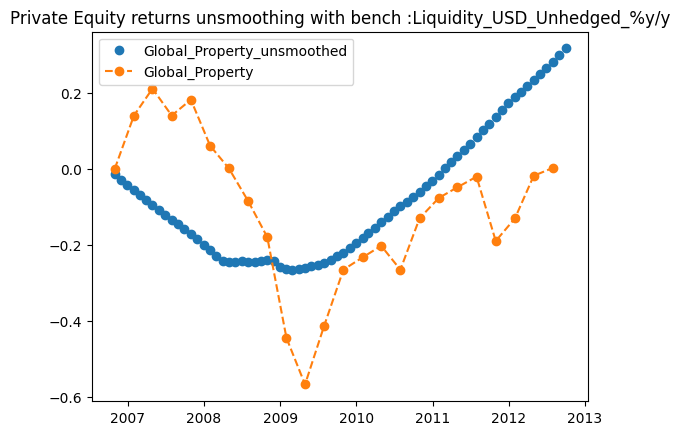

/var/folders/8k/vtlzy2q90b7cbr81gv961g_w0000gn/T/ipykernel_36733/4265356007.py:48: UserWarning: Be careful, Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y has no value for the selected timeframe.
  warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")


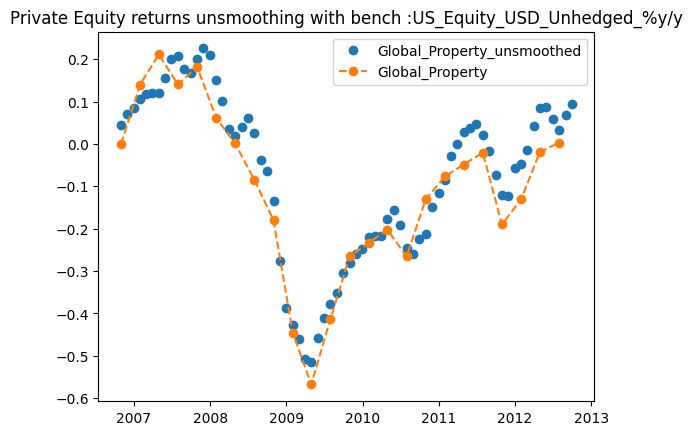

/var/folders/8k/vtlzy2q90b7cbr81gv961g_w0000gn/T/ipykernel_36733/4265356007.py:48: UserWarning: Be careful, Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y has no value for the selected timeframe.
  warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")


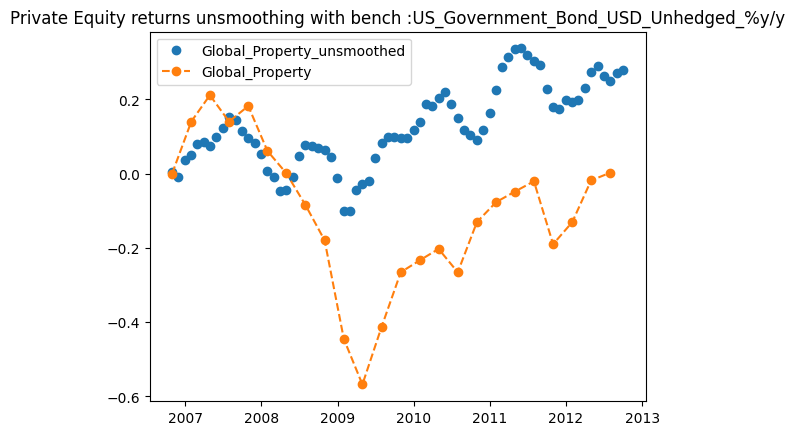

/var/folders/8k/vtlzy2q90b7cbr81gv961g_w0000gn/T/ipykernel_36733/4265356007.py:48: UserWarning: Be careful, Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y has no value for the selected timeframe.
  warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")


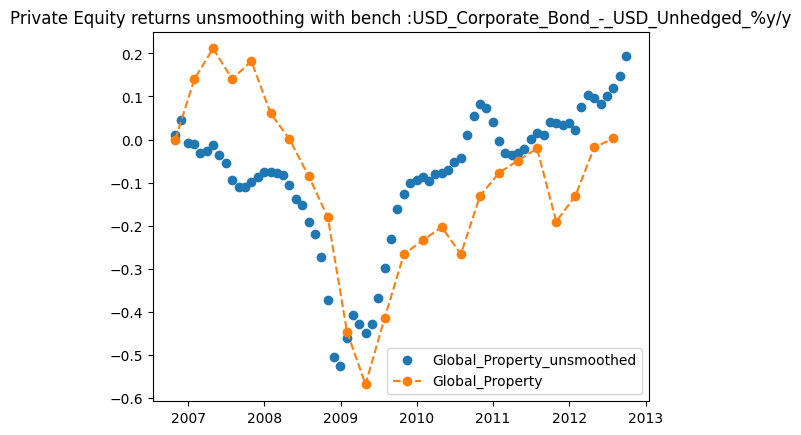

In [ ]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2012-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = None # choose an int or put None
benchmark = 'US_Equity_USD_Unhedged_%y/y' #one of the following list :
# 'Liquidity_USD_Unhedged_%y/y'
# 'US_Equity_USD_Unhedged_%y/y'
# 'US_Government_Bond_USD_Unhedged_%y/y'
# 'USD_Corporate_Bond_-_USD_Unhedged_%y/y'

for benchmark in ['Liquidity_USD_Unhedged_%y/y', 
                  'US_Equity_USD_Unhedged_%y/y',
                  'US_Government_Bond_USD_Unhedged_%y/y',
                  'USD_Corporate_Bond_-_USD_Unhedged_%y/y']:
    df = (
        classic_asset_data
        .copy()
        .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
        .set_index("Date")
        .loc[start_date:end_date]
        .iloc[1:]
    )

    #deal with potential missing values
    if df.isna().any().any():
        df.interpolate(method='linear', inplace=True)

    for col in filter(lambda x: "%y/y" in x, alternative_asset_data.columns):
        getmansky = GetmanskyModel(order)

        if weight_type != "optimized":
            getmansky.set_default_weights(weight_type)
        else:
            getmansky.optimize_weights_LR(df[benchmark].values.reshape(-1, 1), 
                    df[col].values.reshape(-1,1)
                    )
        index = df[col].dropna().index
        if len(index)>3:
            bench = df.loc[index, benchmark]

            getmansky.fit(bench.values.reshape(-1, 1), 
                        df[col].dropna().values.reshape(-1,1), 
                        window = window
                        )
            df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench)
        else:
            warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
            df[col+'_unsmoothed'] = 0


    df = (
        df
        .assign(**{
            col: df[col].mul(pd.Series(
                [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df[col].index],
                index = df[col].index
                )) 
            for col in alternative_asset_data.columns
        })
        .pipe(lambda df_temp: df_temp.assign(**{
            col + '_TR': (df_temp[col]+1).cumprod()-1
            for col in df_temp.columns if "%y/y" in col
        }))
    )



    fig, axes = plt.subplots()

    plt.title("Private Equity returns unsmoothing with bench :" + benchmark)

    plt.plot(df.index, df["Global_Property_USD_Unhedged_%y/y_unsmoothed_TR"],
            marker = 'o',
            linestyle = '',
            label = "Global_Property_unsmoothed")
    plt.plot(df.index[::3], df['Global_Property_USD_Unhedged_%y/y_TR'].iloc[::3],
            marker = 'o',
            linestyle = '--',
            label = "Global_Property")

    plt.legend()
    plt.show()

## Comparison Getmansky vs AR(1)